In [1]:
customer_df = spark.read.csv('file:///home/hadoop/Telco_Customer_Churn(1).csv',inferSchema=True,header=True)

In [2]:
customer_df.createOrReplaceTempView('Customers')
columns = customer_df.columns

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#### a) Analyze how customer retention varies based on how long the customer has stayed with the company (tenure).


<AxesSubplot:xlabel='tenure', ylabel='RetentionRate'>

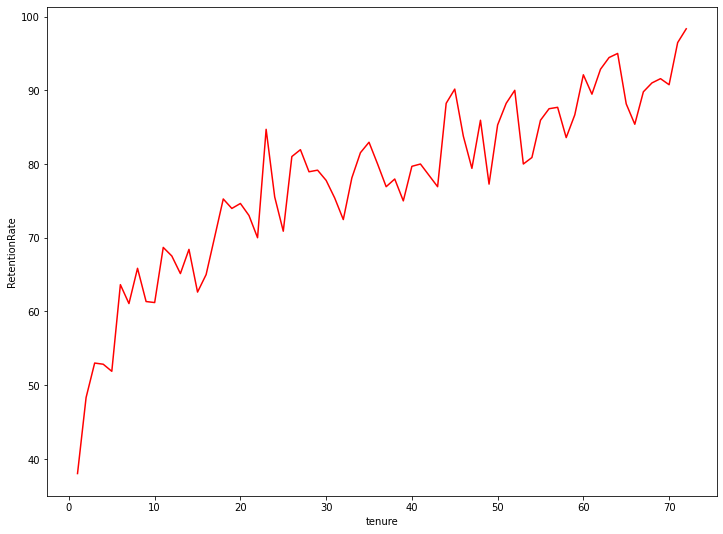

In [4]:
query = """
    SELECT tenure,
    AVG(CASE WHEN Churn = 'No' THEN 1 ELSE 0 END)*100 AS RetentionRate
    FROM customers
    WHERE tenure > 0
    GROUP BY tenure
    ORDER BY Tenure
"""
cust_retention = spark.sql(query).toPandas()

plt.figure(figsize=(12,9))
sns.lineplot(data=cust_retention, x='tenure',y='RetentionRate',color='red')

Insights : 
* Here, there is a positive corelation of tenure and retention rate. We can see a increase in the retention rate as the tenure is increasing.

#### b) Investigate the churn rate of customers who subscribe to streaming services like StreamingTV and StreamingMovies.



([<matplotlib.patches.Wedge at 0x7f8fdc6214e0>,
 [Text(0.6381478911067835, 0.895972805991323, 'Churned'),
  Text(-0.6381479749938088, -0.8959727462436016, 'Non-Churned')],
 [Text(0.34808066787642733, 0.4887124396316307, '30.3%'),
  Text(-0.3480807136329866, -0.48871240704196445, '69.7%')])

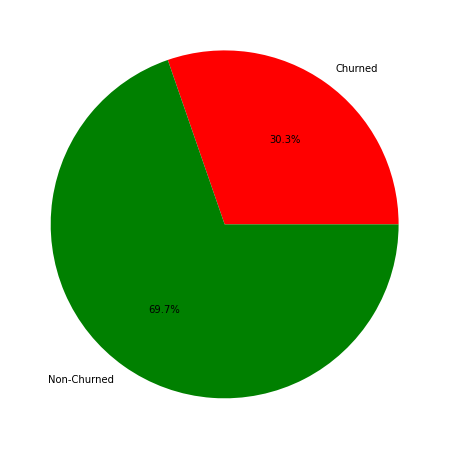

In [148]:
query = """
        SELECT ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END),3) * 100 AS ChurnRate,
        ROUND(AVG(CASE WHEN Churn = 'No' THEN 1 ELSE 0 END),3) * 100 AS ChurnNoRate
        FROM Customers
        WHERE StreamingTV='Yes' OR StreamingMovies='Yes'
"""
subs_df = spark.sql(query).toPandas()

plt.figure(figsize=(12,8))
plt.pie([subs_df['ChurnRate'].values[0],subs_df['ChurnNoRate'].values[0]],
        labels=['Churned','Non-Churned'],autopct='%1.1f%%',
        colors = ['red','green'])

Insights :
* The customers who subscribes to streaming services have a moderate ChurnRate.

#### c) Write Spark SQL to group customers by their tenure (e.g., 0-12 months, 13-24 months, etc.) and analyze churn rates in these tenure groups.


<AxesSubplot:xlabel='TenureGroups', ylabel='ChurnRate'>

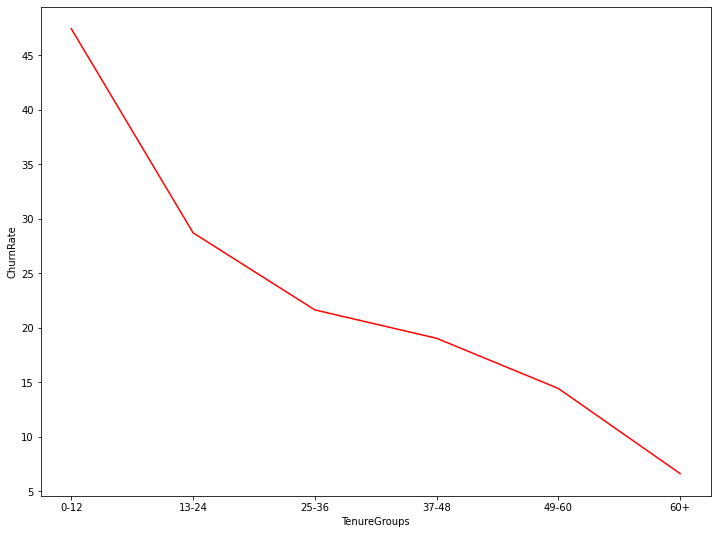

In [6]:
query = """ 
    SELECT CASE
        WHEN tenure BETWEEN 0 AND 12 THEN '0-12'
        WHEN tenure BETWEEN 13 AND 24 THEN '13-24'
        WHEN tenure BETWEEN 25 AND 36 THEN '25-36'
        WHEN tenure BETWEEN 37 AND 48 THEN '37-48'
        WHEN tenure BETWEEN 49 AND 60 THEN '49-60'
        ELSE '60+'
    END AS TenureGroups,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 ChurnRate
    FROM Customers
    GROUP BY TenureGroups
    ORDER BY TenureGroups
"""

tenure_group = spark.sql(query).toPandas()

plt.figure(figsize=(12,9))
sns.lineplot(data=tenure_group, x='TenureGroups',y='ChurnRate',color='red')

Insights : 
* As the tenure increases (yearly) there is a constant decrease in the churn rate. Which indicates a negative corelation between them

#### d) Analyze the impact of contract types and payment methods on churn rates.


Text(0.5, 1.0, 'Churn Rate by Contract and Payment Method')

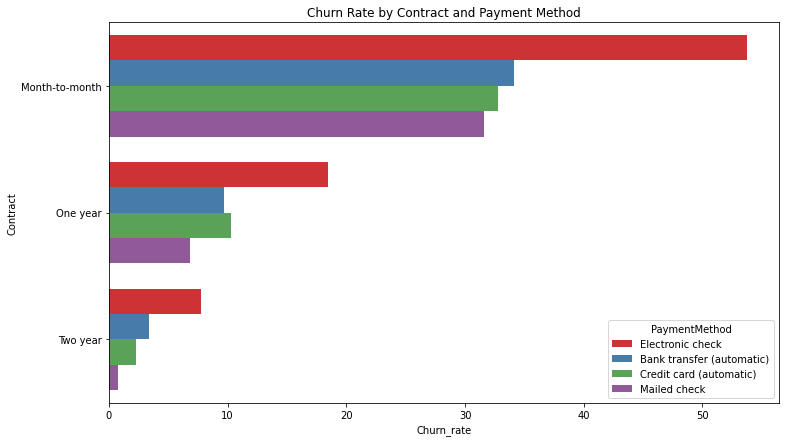

In [7]:
query = """
    SELECT Contract,PaymentMethod,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 as Churn_rate
    FROM Customers
    GROUP BY Contract,PaymentMethod
    ORDER BY Churn_rate desc
"""

contract_df = spark.sql(query).toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(y=contract_df['Contract'], x=contract_df['Churn_rate'],hue=contract_df['PaymentMethod'],
            palette='Set1')

plt.title('Churn Rate by Contract and Payment Method')

Isights : 
* Month to Month Contract with electronic check payment has the maximum churn rate and Two year contract with Mailed check payment has least churn rate. 
* From the graph we can notice that electronic payment has higher churn rate in every contract and Month to Month has high churn rates compared to others. 

#### e) Explore the distribution of monthly charges for customers based on their type of internet service.


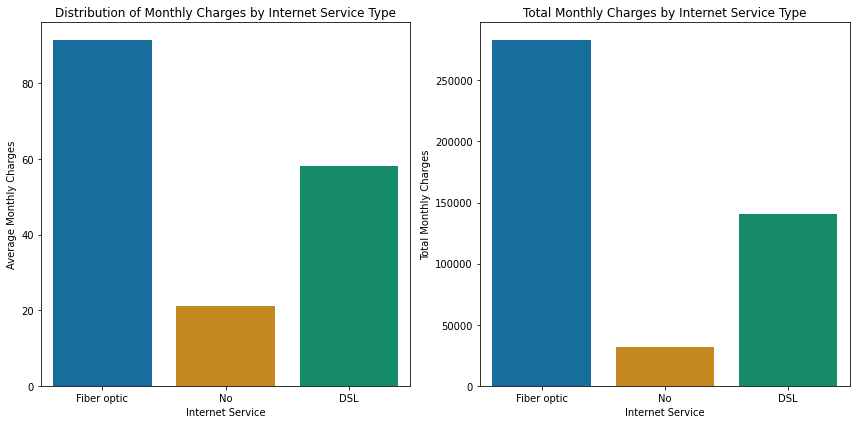

In [8]:
query = """
    SELECT InternetService, AVG(MonthlyCharges) AS avgMonthlyCharges, 
    SUM(MonthlyCharges) AS totalMonthlyCharges
    FROM Customers
    GROUP BY InternetService
"""
monthly_charge = spark.sql(query).toPandas() 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(data=monthly_charge, y='avgMonthlyCharges', x='InternetService', palette='colorblind', ax=axes[0])
axes[0].set_xlabel('Internet Service')
axes[0].set_ylabel('Average Monthly Charges')
axes[0].set_title('Distribution of Monthly Charges by Internet Service Type')

sns.barplot(data=monthly_charge, y='totalMonthlyCharges', x='InternetService', palette='colorblind', ax=axes[1])
axes[1].set_xlabel('Internet Service')
axes[1].set_ylabel('Total Monthly Charges')
axes[1].set_title('Total Monthly Charges by Internet Service Type')

plt.tight_layout()

Insight:
*  Fiber Optics have the most MonthlyCharges and it is the most frequent Internet service.

#### f) Identify the top 10 customers who have contributed the most revenue to the company, based on total charges.


In [9]:
query = """
    SELECT customerID,TotalCharges
    FROM Customers
    ORDER BY TotalCharges DESC
    LIMIT 10
"""
spark.sql(query).show()

+----------+------------+
|customerID|TotalCharges|
+----------+------------+
|9093-FPDLG|       999.9|
|4536-PLEQY|       999.8|
|5899-MQZZL|      999.45|
|6051-PTVNS|       998.1|
|8249-THVEC|      997.75|
|6328-ZPBGN|      997.65|
|7297-DVYGA|      996.95|
|6243-OZGFH|      996.85|
|0484-JPBRU|      996.45|
|2971-SGAFL|      995.35|
+----------+------------+



#### g) Calculate the churn rate segmented by gender and whether the customer is a senior citizen.


In [10]:
query = """
    SELECT 
        gender, 
        CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END AS SeniorCitizen,
        AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 AS Churn_rate
    FROM Customers
    GROUP BY gender, SeniorCitizen
    ORDER BY gender
"""
spark.sql(query).show()

+------+-------------+------------------+
|gender|SeniorCitizen|        Churn_rate|
+------+-------------+------------------+
|Female|          Yes| 42.25352112676056|
|Female|           No|23.938356164383563|
|  Male|          Yes| 41.11498257839721|
|  Male|           No|23.280778262328077|
+------+-------------+------------------+



#### h) Write query to calculate Correlation between dependents and churn. Explore whether having dependents affects
#### customer churn rates.

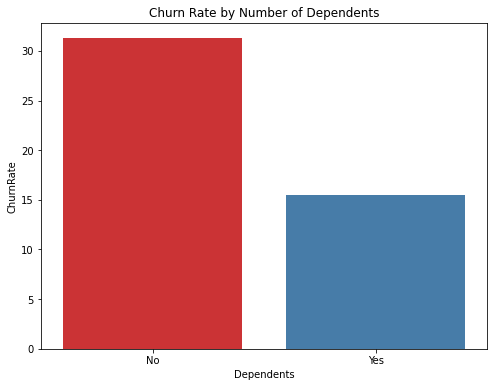

In [11]:
query = """
    SELECT 
    Dependents,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END)*100 AS ChurnRate
    FROM Customers
    GROUP BY Dependents
"""

dependent_df = spark.sql(query).toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=dependent_df, x='Dependents', y='ChurnRate', palette='Set1')
plt.title('Churn Rate by Number of Dependents')
plt.show()


Insights :
* Having Dependents reduces the Churn Rate by half compared to the cusomters without Dependents.

#### i) Predict potential churn rates by analyzing the relationship between monthly charges, contract types, and the
#### churn rate.


Text(0.5, 1.0, 'Relation between Monthly charges and Contract types')

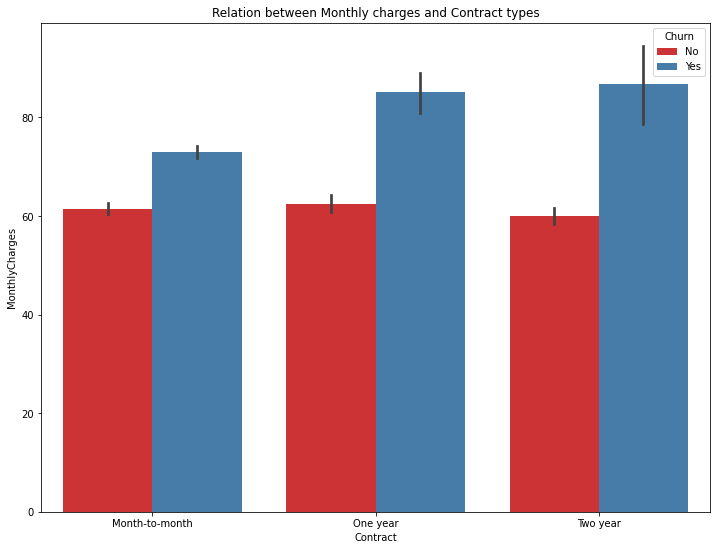

In [12]:
query = """
    SELECT MonthlyCharges, Contract, Churn
    FROM Customers
"""

monthly_depend = spark.sql(query).toPandas()

plt.figure(figsize=(12,9))
sns.barplot(data=monthly_depend, x='Contract',y='MonthlyCharges',hue='Churn',palette='Set1')
plt.title('Relation between Monthly charges and Contract types')

In every Contract types, when monthly charges are increasing the Churn rate also increases. Two year Contract has the highest variation with in churn rate when the monthly charges is increasing.

#### j) Determine the churn rate for customers who have multiple services (Phone, Internet, and Streaming), which can
#### help understand whether bundling services leads to higher or lower churn. Calculate churn rate for customers
#### with multiple services.


In [13]:
query = """
    SELECT 
        CASE 
            WHEN PhoneService = 'Yes' AND InternetService <> 'No' AND StreamingTV = 'Yes' THEN 'Phone + Internet + StreamingTV'
            WHEN PhoneService = 'Yes' AND InternetService <> 'No' AND StreamingMovies = 'Yes' THEN 'Phone + Internet + StreamingMovies'
            WHEN PhoneService = 'Yes' AND InternetService <> 'No' THEN 'Phone + Internet'
            ELSE 'Other'
        END AS ServiceCombination,
        ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END), 3)* 100 AS ChurnRate,
        COUNT(*) AS CustomerCount
    FROM Customers
    WHERE PhoneService = 'Yes' OR InternetService <> 'No' OR StreamingTV = 'Yes' OR StreamingMovies = 'Yes'
    GROUP BY ServiceCombination
"""
spark.sql(query).toPandas()

,ServiceCombination,ChurnRate,CustomerCount
0,Phone + Internet + StreamingTV,31.0,2422
1,Phone + Internet + StreamingMovies,31.4,694
2,Other,12.8,2208
3,Phone + Internet,36.0,1719


Insights : 
* Customers with multiple services has less churn rate.

#### k) Churn Impact by device protection and online backup services. Write query to investigate whether having device
#### protection or online backup services affects churn rates.


In [150]:
query = """
    SELECT ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100,4) ChurnRate
    FROM Customers
    WHERE OnlineBackup = 'Yes' OR DeviceProtection = 'Yes'
"""

spark.sql(query).show()

+---------+
|ChurnRate|
+---------+
|  23.9174|
+---------+



Insights : 
* Customers with backup services or device protection has less churn rates

#### l) Explore churn rates among customers who do not have phone service and investigate if it influences customer
#### retention.


In [15]:
query = """
    SELECT PhoneService,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 ChurnRate
    FROM Customers
    GROUP BY PhoneService
"""

spark.sql(query).show()

+------------+------------------+
|PhoneService|         ChurnRate|
+------------+------------------+
|          No|24.926686217008797|
|         Yes| 26.70963684955196|
+------------+------------------+



* The customers who have Phone Service have slightly high ChurnRate than customers who has No Phone Service.

#### m) Understand the relationship between payment methods and contract types on customer churn. This query will
#### help you discover which combinations are most prone to churn.


Text(0.5, 1.0, 'Churn Rate by Contract and Payment Method')

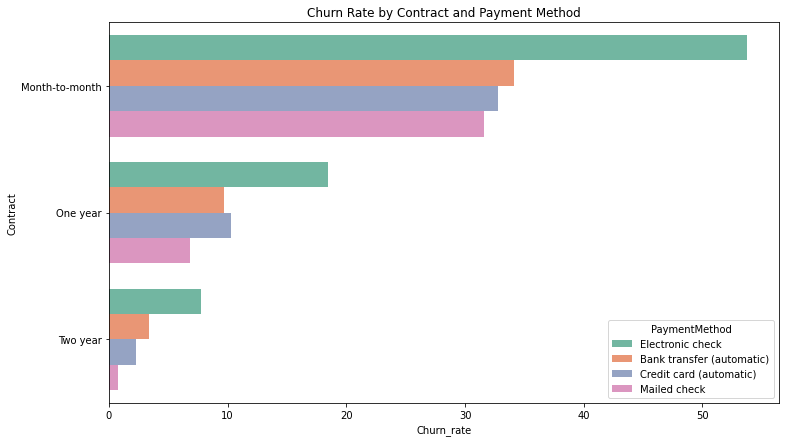

In [16]:
query = """
    SELECT Contract,PaymentMethod,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 as Churn_rate
    FROM Customers
    GROUP BY Contract,PaymentMethod
    ORDER BY Churn_rate desc
"""

contract_df = spark.sql(query).toPandas()


plt.figure(figsize=(12, 7))
sns.barplot(y=contract_df['Contract'], x=contract_df['Churn_rate'],hue=contract_df['PaymentMethod'], palette='Set2')

plt.title('Churn Rate by Contract and Payment Method')

Insights :
* Month-to-Month Contract type with Electronic check payment method is prone to high churn rate.

#### n) Analyze how customer churn is affected by senior citizen status and whether the customer has dependents.


Text(0.5, 1.0, 'Churn Rate by Contract and Payment Method')

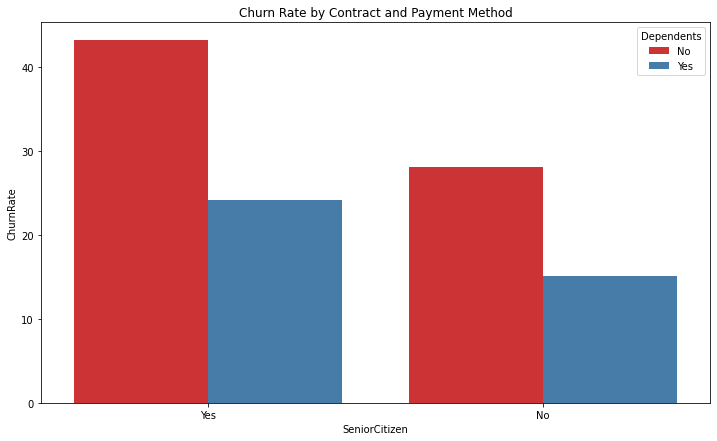

In [17]:
query = """
    SELECT CASE WHEN SeniorCitizen=0 THEN 'No' ELSE 'Yes' END as SeniorCitizen,
    Dependents,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 ChurnRate
    FROM Customers
    GROUP BY SeniorCitizen,Dependents
"""
senior_cust = spark.sql(query).toPandas()
plt.figure(figsize=(12, 7))
sns.barplot(data=senior_cust,x='SeniorCitizen',y='ChurnRate',hue='Dependents', palette='Set1')

plt.title('Churn Rate by Contract and Payment Method')

Insights : 
* Customers who are Senior Citizens and having No Dependents has greater Churn Rate than the other customers.

#### o) Explore whether subscribing to streaming services like Streaming TV and Streaming Movies influences the churn
#### rate.


<AxesSubplot:xlabel='StreamingTV', ylabel='ChurnRate'>

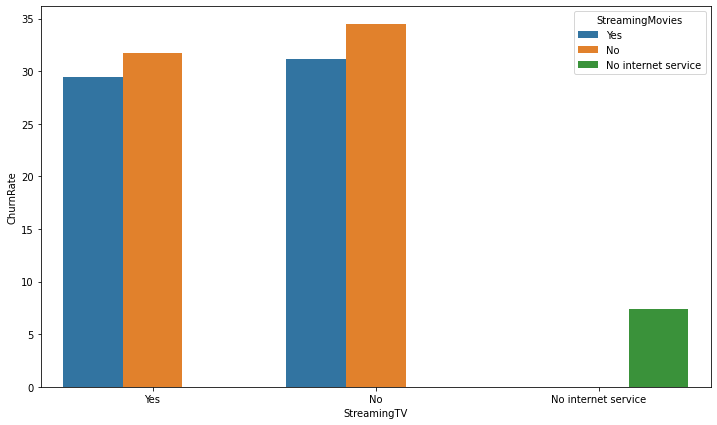

In [18]:
query = """
        SELECT StreamingTV, StreamingMovies,
        AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 AS ChurnRate,
        COUNT(*) AS CustomerCount FROM Customers 
        GROUP BY StreamingTV, StreamingMovies
"""
stream_churn = spark.sql(query).toPandas()

plt.figure(figsize=(12,7))
sns.barplot(data=stream_churn , x='StreamingTV',hue='StreamingMovies',y='ChurnRate')

Insights :
* There is a slight decrease in churn rate when customers are subscribed to either tv or movie streaming.

#### p) Understand how tenure and MonthlyCharges differ between churned and non-churned customers. This can
#### provide insights into the behavior of long-term customers.


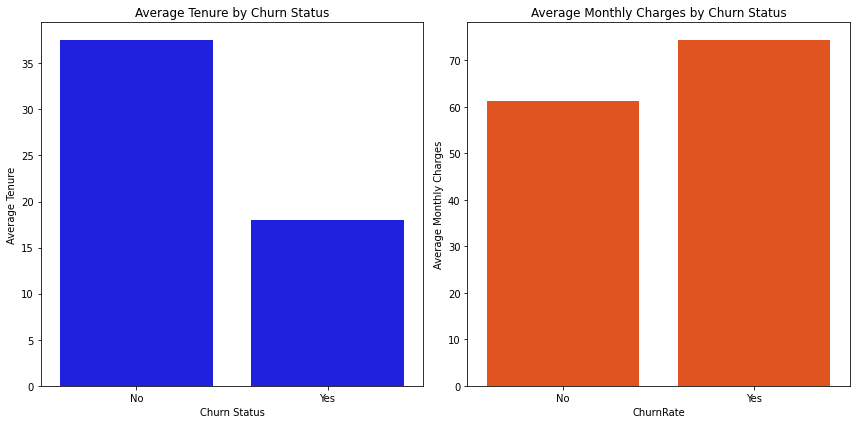

In [19]:
query = """
    SELECT Churn,
    AVG(tenure) as AvgTenure,
    AVG(MonthlyCharges) as AvgMonthlyCharges
    FROM Customers
    GROUP BY Churn
"""

churn_data_pd = spark.sql(query).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(data=churn_data_pd, x='Churn', y='AvgTenure', color='blue', ax=axes[0])
axes[0].set_title('Average Tenure by Churn Status')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Average Tenure')

sns.barplot(data=churn_data_pd, x='Churn', y='AvgMonthlyCharges', color='orangered', ax=axes[1])
axes[1].set_title('Average Monthly Charges by Churn Status')
axes[1].set_xlabel('ChurnRate')
axes[1].set_ylabel('Average Monthly Charges')

plt.tight_layout()
plt.show()

Insights:
*   When tenure is high and monthly rate is low then the Churn rate is less.

#### q) Compare monthly charges and churn rates between newer customers and long-time customers.


<AxesSubplot:>

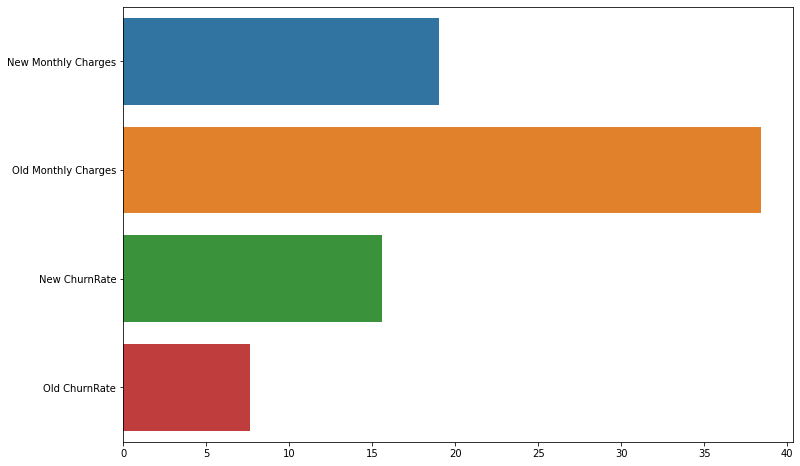

In [67]:
query = """
    SELECT
    AVG(CASE WHEN Churn = 'Yes' AND tenure < 15 THEN 1 ELSE 0 END) * 100 NewerChurn,
    AVG(CASE WHEN tenure < 15 THEN MonthlyCharges ELSE 0 END) NewerCharge,
    AVG(CASE WHEN Churn = 'Yes' AND tenure > 24 THEN 1 ELSE 0 END) * 100 olderChurn,
    AVG(CASE WHEN tenure > 24 THEN MonthlyCharges ELSE 0 END) olderCharges
    FROM Customers
"""

monthly_df = spark.sql(query).toPandas() 
plt.figure(figsize=(12,8))
sns.barplot( y=['New Monthly Charges','Old Monthly Charges','New ChurnRate','Old ChurnRate'],
            x=[monthly_df['NewerCharge'].values[0],monthly_df['olderCharges'].values[0],
               monthly_df['NewerChurn'].values[0],monthly_df['olderChurn'].values[0]])

Insights :
*  Newer customers have less Monthly Charges whereas Older customers have more. Churn rate is more for the newer customers and it is less for the older cusomers.




#### r) What is the correlation between senior citizen status and churn rate?

Text(0.5, 1.0, 'Churn Rate of Senior Citizens')

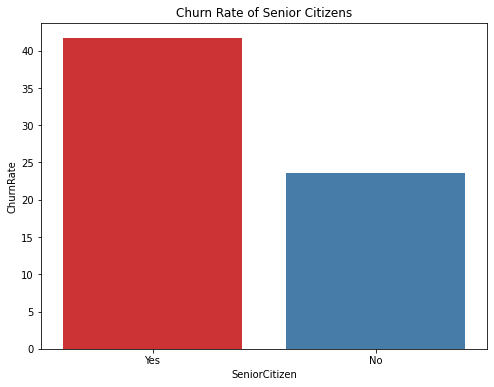

In [69]:

query = """
    SELECT 
    CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END AS SeniorCitizen,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END)*100 AS ChurnRate
    FROM Customers
    GROUP BY SeniorCitizen
"""

dependent_df = spark.sql(query).toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=dependent_df, x='SeniorCitizen', y='ChurnRate', palette='Set1')
plt.title('Churn Rate of Senior Citizens')

Insight :
* There is an increase in ChurnRate if the customers belong to Senior Citizen category.

#### s) Partition customers based on whether they are senior citizens and divide them into 5 groups based on tenure.
#### [Use NTILE.]


In [33]:
query = """
    SELECT 
        CustomerID,
        CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END AS SeniorCitizen,
        tenure,
        NTILE(5) OVER (PARTITION BY CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END ORDER BY tenure) AS tenure_ntile
        FROM Customers
    ORDER BY SeniorCitizen , tenure_ntile
"""

spark.sql(query).show()

+----------+-------------+------+------------+
|CustomerID|SeniorCitizen|tenure|tenure_ntile|
+----------+-------------+------+------------+
|3930-ZGWVE|           No|     1|           1|
|7590-VHVEG|           No|     1|           1|
|3679-XASPY|           No|     1|           1|
|3213-VVOLG|           No|     0|           1|
|2775-SEFEE|           No|     0|           1|
|7310-EGVHZ|           No|     1|           1|
|6380-ARCEH|           No|     1|           1|
|5709-LVOEQ|           No|     0|           1|
|7644-OMVMY|           No|     0|           1|
|2923-ARZLG|           No|     0|           1|
|4075-WKNIU|           No|     0|           1|
|1066-JKSGK|           No|     1|           1|
|8665-UTDHZ|           No|     1|           1|
|2273-QCKXA|           No|     1|           1|
|5919-TMRGD|           No|     1|           1|
|4472-LVYGI|           No|     0|           1|
|3115-CZMZD|           No|     0|           1|
|4367-NUYAO|           No|     0|           1|
|1371-DWPAZ| 

#### t) Use PERCENT_RANK to identify the top 5% of customers by MonthlyCharges.


In [23]:
query = """
SELECT CustomerID,MonthlyCharges, MonthlyRank
FROM (
    SELECT CustomerID,MonthlyCharges,
        PERCENT_RANK() OVER (ORDER BY MonthlyCharges) AS MonthlyRank
    FROM Customers
) _
WHERE MonthlyRank < 0.05
ORDER BY MonthlyRank
"""

spark.sql(query).show()

+----------+--------------+--------------------+
|CustomerID|MonthlyCharges|         MonthlyRank|
+----------+--------------+--------------------+
|6823-SIDFQ|         18.25|                 0.0|
|9764-REAFF|          18.4|1.420051121840386...|
|0827-ITJPH|         18.55|2.840102243680772...|
|0621-CXBKL|          18.7|4.260153365521159E-4|
|9945-PSVIP|          18.7|4.260153365521159E-4|
|9426-SXNHE|         18.75|7.100255609201931E-4|
|6508-NJYRO|          18.8|8.520306731042318E-4|
|2967-MXRAV|          18.8|8.520306731042318E-4|
|7369-TRPFD|          18.8|8.520306731042318E-4|
|8464-EETCQ|          18.8|8.520306731042318E-4|
|3387-PLKUI|          18.8|8.520306731042318E-4|
|7473-ZBDSN|          18.8|8.520306731042318E-4|
|3806-YAZOV|          18.8|8.520306731042318E-4|
|0620-XEFWH|         18.85|0.001846066458392502|
|5863-OOKCL|         18.85|0.001846066458392502|
|3572-UUHRS|         18.85|0.001846066458392502|
|8992-CEUEN|         18.85|0.001846066458392502|
|9318-NKNFC|        

#### u) Find customers who fall within the top 5% of the distribution based on monthly charges. Compare total charges
#### with the next customer in the same internet service type, based on monthly charges.


In [24]:
query = """
    SELECT CustomerID,InternetService,MonthlyCharges,TotalCharges,next_charge,
    ROUND((TotalCharges - next_charge),3) Charge_diff
    FROM (
        SELECT CustomerID,InternetService,MonthlyCharges,TotalCharges,
        PERCENT_RANK() OVER (ORDER BY MonthlyCharges DESC) AS MonthlyRank,
        LEAD(TotalCharges) OVER(PARTITION BY InternetService ORDER BY MonthlyCharges DESC) next_charge
        FROM Customers
    ) _
    WHERE MonthlyRank <= 0.05
    ORDER BY MonthlyRank
"""

spark.sql(query).show()

+----------+---------------+--------------+------------+-----------+-----------+
|CustomerID|InternetService|MonthlyCharges|TotalCharges|next_charge|Charge_diff|
+----------+---------------+--------------+------------+-----------+-----------+
|7569-NMZYQ|    Fiber optic|        118.75|     8672.45|     8477.6|     194.85|
|8984-HPEMB|    Fiber optic|        118.65|      8477.6|    7990.05|     487.55|
|5989-AXPUC|    Fiber optic|         118.6|     7990.05|     7365.7|     624.35|
|5734-EJKXG|    Fiber optic|         118.6|      7365.7|    7804.15|    -438.45|
|8199-ZLLSA|    Fiber optic|        118.35|     7804.15|    8547.15|     -743.0|
|9924-JPRMC|    Fiber optic|         118.2|     8547.15|     8684.8|    -137.65|
|2889-FPWRM|    Fiber optic|         117.8|      8684.8|     8308.9|      375.9|
|3810-DVDQQ|    Fiber optic|         117.6|      8308.9|     8670.1|     -361.2|
|9739-JLPQJ|    Fiber optic|         117.5|      8670.1|     5438.9|     3231.2|
|2302-ANTDP|    Fiber optic|

#### v) Find the top 5 customers with the highest MonthlyCharges within each Contract type.


In [25]:
query = """
    SELECT * FROM (
        SELECT CustomerID,Contract,MonthlyCharges,
        ROW_NUMBER() OVER(PARTITION BY Contract ORDER BY MonthlyCharges) ChargeRank
        FROM Customers
    ) _
    WHERE ChargeRank <=5
"""

spark.sql(query).show()

+----------+--------------+--------------+----------+
|CustomerID|      Contract|MonthlyCharges|ChargeRank|
+----------+--------------+--------------+----------+
|9426-SXNHE|Month-to-month|         18.75|         1|
|3806-YAZOV|Month-to-month|          18.8|         2|
|3387-PLKUI|Month-to-month|          18.8|         3|
|8992-CEUEN|Month-to-month|         18.85|         4|
|0620-XEFWH|Month-to-month|         18.85|         5|
|6823-SIDFQ|      One year|         18.25|         1|
|2967-MXRAV|      One year|          18.8|         2|
|7369-TRPFD|      One year|          18.8|         3|
|6508-NJYRO|      One year|          18.8|         4|
|3572-UUHRS|      One year|         18.85|         5|
|9764-REAFF|      Two year|          18.4|         1|
|0827-ITJPH|      Two year|         18.55|         2|
|0621-CXBKL|      Two year|          18.7|         3|
|9945-PSVIP|      Two year|          18.7|         4|
|7473-ZBDSN|      Two year|          18.8|         5|
+----------+--------------+-

#### w) Calculate the churn rate in each Contract type and rank the contracts by churn rate.


In [26]:
query = """
    SELECT Contract,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) ,3) ChurnRate,
    RANK() OVER(ORDER BY AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END)) ChurnRank
    FROM Customers
    GROUP BY Contract
"""

spark.sql(query).show()

+--------------+---------+---------+
|      Contract|ChurnRate|ChurnRank|
+--------------+---------+---------+
|      Two year|    0.028|        1|
|      One year|    0.113|        2|
|Month-to-month|    0.427|        3|
+--------------+---------+---------+



#### x) Perform an in-depth analysis of customers using window functions to understand customer rankings,
#### distribution, and trends in charges and tenure.

In [134]:
query1 = """
    SELECT
    customerID,
    MonthlyCharges,
    tenure,
    TotalCharges,
    AVG(TotalCharges) OVER(ORDER BY MonthlyCharges DESC) AS ChargeDistribution,
    AVG(tenure) OVER(ORDER BY MonthlyCharges DESC) AS TenureDistribution,
    DENSE_RANK() OVER (ORDER BY MonthlyCharges DESC) AS CustomerRank
    FROM customers
    ORDER BY CustomerRank
"""

spark.sql(query1).toPandas()

,customerID,MonthlyCharges,tenure,TotalCharges,ChargeDistribution,TenureDistribution,CustomerRank
0,7569-NMZYQ,118.75,72,8672.45,8672.450000,72.000000,1
1,8984-HPEMB,118.65,71,8477.6,8575.025000,71.500000,2
2,5989-AXPUC,118.60,68,7990.05,8126.450000,68.000000,3
3,5734-EJKXG,118.60,61,7365.7,8126.450000,68.000000,3
4,8199-ZLLSA,118.35,67,7804.15,8061.990000,67.800000,4
...,...,...,...,...,...,...,...
7038,0621-CXBKL,18.70,53,1005.7,2283.950370,32.367472,1582
7039,9945-PSVIP,18.70,25,383.65,2283.950370,32.367472,1582
7040,0827-ITJPH,18.55,36,689,2283.723492,32.367988,1583
7041,9764-REAFF,18.40,59,1057.85,2283.549140,32.371769,1584


Insights:
*  The Customers who pay more charge tend to stay with the company for a long time, which makes them high in ranking. There is a decrease in average tenure when the total spend are decreasing.

In [136]:
query = """
    SELECT COUNT(*) count,
    ROUND(AVG(MonthlyCharges),3) meanCharge,
    ROUND(AVG(tenure),3) meanTenure,
    MIN(MonthlyCharges) minCharge,
    MIN(tenure) minTenure,
    Max(MonthlyCharges) maxCharge,
    Max(tenure) maxTenure,
    ROUND(STDDEV(MonthlyCharges),4) stddevCharge,
    ROUND(STDDEV(tenure),4) stddevTenure
    FROM customers
"""

spark.sql(query).show()

+-----+----------+----------+---------+---------+---------+---------+------------+------------+
|count|meanCharge|meanTenure|minCharge|minTenure|maxCharge|maxTenure|stddevCharge|stddevTenure|
+-----+----------+----------+---------+---------+---------+---------+------------+------------+
| 7043|    64.762|    32.371|    18.25|        0|   118.75|       72|       30.09|     24.5595|
+-----+----------+----------+---------+---------+---------+---------+------------+------------+



Insight:
*   Average Monthly Charge is 64.76 and average Tenure is 32, Most of the monthly charge lies between 34 to 94. 
    Maximum Charge paid by a customer is 118 and longest a customer stayed is 72 months(6 years).

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

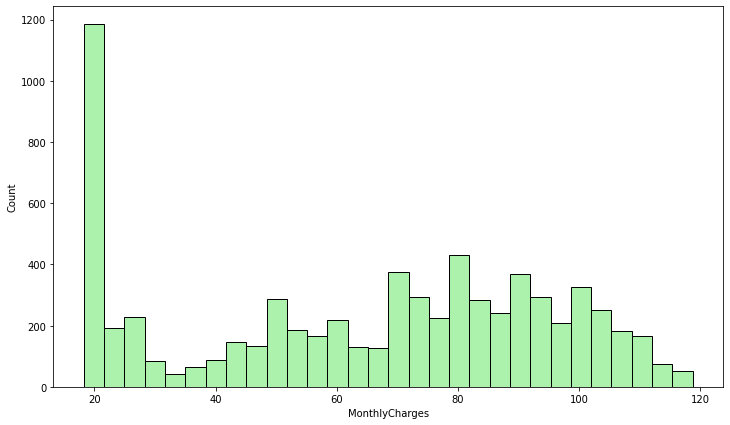

In [120]:
Depth_df = spark.sql('SELECT MonthlyCharges FROM Customers WHERE MonthlyCharges > 0').toPandas()

plt.figure(figsize=(12,7))
sns.histplot(Depth_df['MonthlyCharges'],bins=30,color='lightgreen')